# Mapping salt in 2-D seismic image using a U-Net
This tutorial describes how to map salt in a 2-D seismic image using a U-Net type convolutional neural network. A U-Net is network, which is able to predict the label of each pixel of an image, thus allowing much faster predictions than pixel-wise classification models (tutorial-1).[link text](https://)

## Setup ##

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-2/tutorial-2.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


## Pre-processing ##
Now that everything is set up, we want to load our data, but first we need to load a couple of useful python packages:


In [4]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

Next we clone the Github repository to get our data:

In [5]:
!git clone https://github.com/thilowrona/seismic_deep_learning

fatal: destination path 'seismic_deep_learning' already exists and is not an empty directory.


Now you can load and plot the seismic image and its mask:

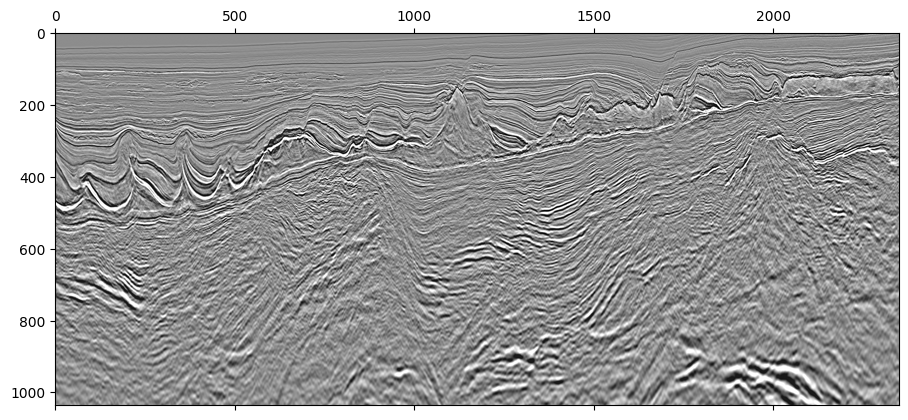

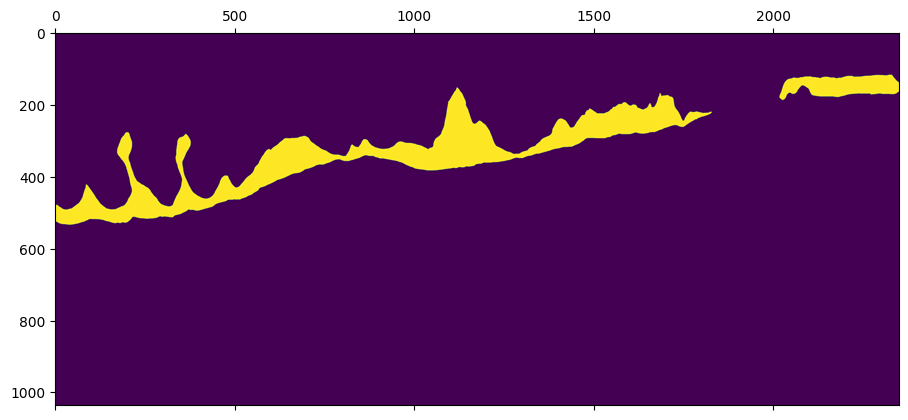

In [26]:
# Load the seismic image data as a NumPy array (values in range [0, 255])
data = mpimg.imread('seismic_deep_learning/tutorial-01/seismic.tif')

# Keep only the first channel (grayscale) and normalize pixel values to [0, 1]
# This standardization is often needed before feeding into neural networks
data = data[:, :, :1] / 255

# Load the corresponding mask image (same dimensions as seismic data)
mask = mpimg.imread('seismic_deep_learning/tutorial-01/mask.tif').copy()

# Normalize the mask values to range [0, 1]
# This makes it compatible for training models, especially if soft masks are used
mask = (mask - mask.min()) / (mask.max() - mask.min())

# Visualize the seismic data (grayscale image)
plt.matshow(data[:, :, 0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.show()

# Visualize the corresponding mask (color map not specified to use default)
plt.matshow(mask, interpolation='spline16', aspect=1)
plt.show()


So now we have one image with a mask, but we need many more examples to train a deep learning model. Of course, we could label more examples, but that takes time and additional data. Let's say we have neither of those. In this case, we can split up our image and mask in to many pairs of small patches. So let's do this:

In [21]:
# Define parameters for patch extraction
patch_num  = 10000   # Total number of patches to extract
patch_size = 128     # Width and height of each square patch
val_split  = 0.2     # Fraction of data reserved for validation

# Function to extract random patches from the input data and corresponding mask
def extract_patches(data, mask, patch_num, patch_size):

  # Initialize empty arrays to hold input (X) and target (Y) patches
  # Shape: (number of patches, patch height, patch width, 1 channel)
  X = np.empty((patch_num, patch_size, patch_size, 1))
  Y = np.empty((patch_num, patch_size, patch_size, 1))

  # Get the dimensions of the input data
  (t_max, x_max, _) = data.shape

  for n in range(patch_num):

      # Randomly select a central point for the patch
      # Ensure it's far enough from the edges to extract a full patch
      x_n = random.randint(patch_size // 2, x_max - patch_size // 2)
      t_n = random.randint(patch_size // 2, t_max - patch_size // 2)

      # Extract the patch centered at (t_n, x_n) from the data and mask
      # Add a singleton channel dimension for compatibility with CNNs
      X[n, :, :, 0] = data[t_n - patch_size // 2:t_n + patch_size // 2,
                           x_n - patch_size // 2:x_n + patch_size // 2, 0]
      Y[n, :, :, 0] = mask[t_n - patch_size // 2:t_n + patch_size // 2,
                           x_n - patch_size // 2:x_n + patch_size // 2]

  return X, Y

# Extract training patches from the left half of the image (0 to 1500 in x-direction)
# The number of patches is reduced according to the validation split
X_train, Y_train = extract_patches(data[:, :1500], mask[:, :1500],
                                   int(patch_num * (1 - val_split)), patch_size)

# Extract validation patches from the right half of the image (1500 to end in x-direction)
X_val, Y_val = extract_patches(data[:, 1500:], mask[:, 1500:],
                               int(patch_num * val_split), patch_size)


Before training, it's always a good idea to check the training data, so let's do that:

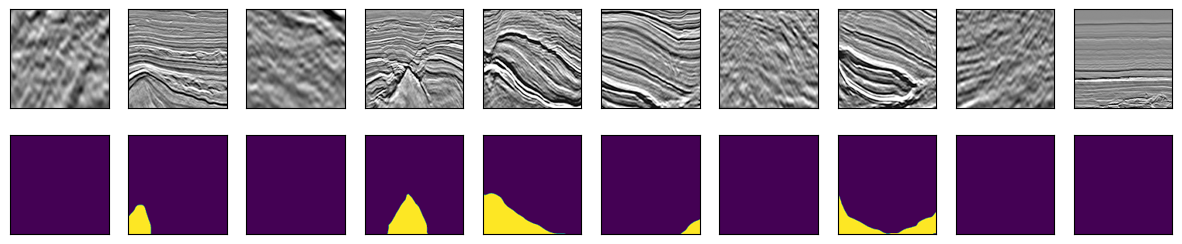

In [25]:
# Create a figure with 2 rows and 10 columns of subplots
# The entire figure will be 15 inches wide and 3 inches tall
fig, axs = plt.subplots(2, 10, figsize=(15, 3))

k = 0  # Patch index to visualize

# Plot the first 10 training input patches (X_train)
for m in range(10):
    axs[0, m].imshow(X_train[k, :, :, 0],                # Display the k-th input patch
                     interpolation='spline16',           # Smooth interpolation for better visualization
                     cmap=plt.cm.gray,                   # Use grayscale colormap
                     aspect=1)                           # Keep aspect ratio square
    axs[0, m].set_xticks([])                             # Remove x-axis ticks
    axs[0, m].set_yticks([])                             # Remove y-axis ticks
    k += 1

k = 0  # Reset patch index

# Plot the corresponding target patches (Y_train) in the second row
for m in range(10):
    axs[1, m].imshow(Y_train[k, :, :, 0],                # Display the k-th target patch (segmentation mask)
                     interpolation='spline16',           # Use same interpolation for consistency
                     aspect=1)                           # Keep aspect ratio square
    axs[1, m].set_xticks([])                             # Remove x-axis ticks
    axs[1, m].set_yticks([])                             # Remove y-axis ticks
    k += 1


What do you notice?

* Is it an easy task?
* Could you predict the masks?
* Can we learn more from some examples?

### Training ##
To train our model, we need to define its architecture.



In [27]:
# Define a single downsampling block used in the encoder path
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    # Two convolutional layers with ReLU activation
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    # Downsample using max pooling
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p  # Return both the conv output (for skip connection) and the pooled output

# Define an upsampling block used in the decoder path
def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    # Upsample the input feature map
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    # Concatenate with the corresponding encoder feature map (skip connection)
    concat = tf.keras.layers.Concatenate()([us, skip])
    # Two convolutional layers with ReLU activation
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

# Define the bottleneck (deepest) part of the U-Net
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    # Two convolutional layers without downsampling
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

# Define the full U-Net architecture
def UNet():
    f = [16, 32, 64, 128, 256]  # Number of filters at each level

    # Input layer for a patch-sized image with 1 channel
    inputs = tf.keras.layers.Input((patch_size, patch_size, 1))

    # Encoder path (contracting)
    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128x128 -> 64x64
    c2, p2 = down_block(p1, f[1])  # 64x64 -> 32x32
    c3, p3 = down_block(p2, f[2])  # 32x32 -> 16x16
    c4, p4 = down_block(p3, f[3])  # 16x16 -> 8x8

    # Bottleneck (lowest resolution, most abstract features)
    bn = bottleneck(p4, f[4])

    # Decoder path (expanding)
    u1 = up_block(bn, c4, f[3])  # 8x8 -> 16x16
    u2 = up_block(u1, c3, f[2])  # 16x16 -> 32x32
    u3 = up_block(u2, c2, f[1])  # 32x32 -> 64x64
    u4 = up_block(u3, c1, f[0])  # 64x64 -> 128x128

    # Final convolution to map to 1 output channel (binary mask), using sigmoid for probability
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)

    # Create the Keras model
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Instantiate and compile the model
model = UNet()
model.compile(
    optimizer="adam",                    # Adaptive optimizer
    loss="binary_crossentropy",         # Binary segmentation loss
    metrics=["acc"]                     # Monitor accuracy during training
)


Now you can train your first convolutional neural net:

In [28]:
history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=3)

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - acc: 0.9031 - loss: 0.3081 - val_acc: 0.9531 - val_loss: 0.1546
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - acc: 0.9551 - loss: 0.1256 - val_acc: 0.9382 - val_loss: 0.2028
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - acc: 0.9722 - loss: 0.0754 - val_acc: 0.9434 - val_loss: 0.2420


To visualize our training, you can plot learning curves:

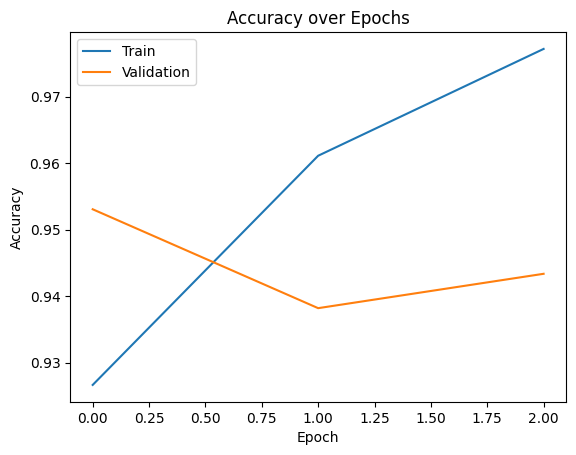

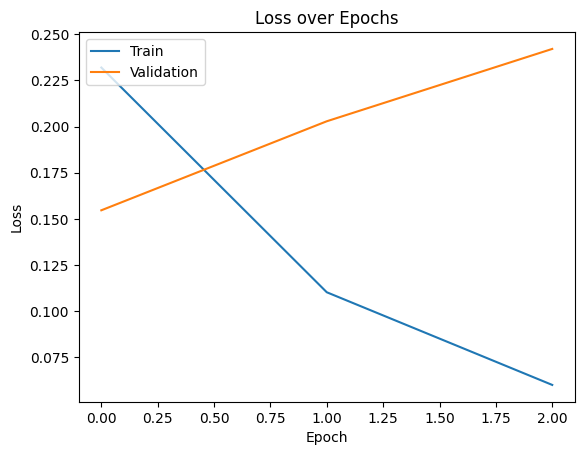

In [29]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['acc'])         # Training accuracy
plt.plot(history.history['val_acc'])     # Validation accuracy
plt.title('Accuracy over Epochs')        # Title of the plot
plt.ylabel('Accuracy')                   # Label for y-axis
plt.xlabel('Epoch')                      # Label for x-axis
plt.legend(['Train', 'Validation'], loc='upper left')  # Legend to distinguish lines
plt.show()                               # Display the plot

# Plot training and validation loss over epochs
plt.plot(history.history['loss'])        # Training loss
plt.plot(history.history['val_loss'])    # Validation loss
plt.title('Loss over Epochs')            # Title of the plot
plt.ylabel('Loss')                       # Label for y-axis
plt.xlabel('Epoch')                      # Label for x-axis
plt.legend(['Train', 'Validation'], loc='upper left')  # Legend to distinguish lines
plt.show()                               # Display the plot


Confusion matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


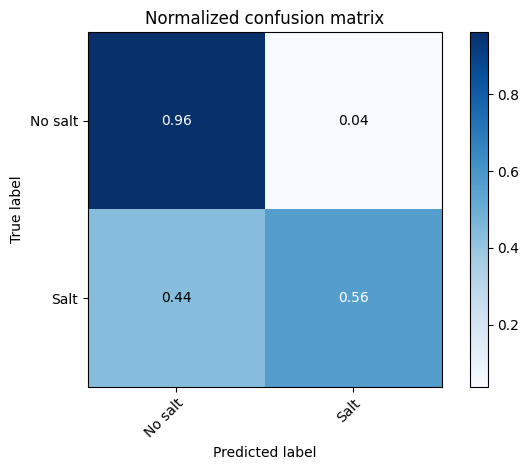

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predict segmentation masks for the validation set
Y_pred = model.predict(X_val)

# Ground truth labels
Y_true = Y_val

# Initialize confusion matrix for binary classification: [[TN, FP], [FN, TP]]
cm = np.zeros((2, 2))

# Loop through each patch in the validation set
for n in range(Y_true.shape[0]):

    # Flatten the ground truth and prediction masks into 1D arrays
    y_true = Y_true[n, :, :, 0].round().flatten()
    y_pred = Y_pred[n, :, :, 0].round().flatten()

    # Compute confusion matrix for the current patch
    cm_batch = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Handle rare cases where only one class appears in the patch
    if cm_batch.shape == (1, 1):
        cm[0, 0] += cm_batch[0, 0]
    else:
        cm += cm_batch  # Accumulate per-patch confusion matrix

# ---------- Confusion Matrix Visualization ---------- #

# Set parameters for visualization
cmap = plt.cm.Blues
normalize = True
title = 'Normalized confusion matrix'
classes = ['No salt', 'Salt']  # Labels for classes

# Normalize confusion matrix by row (i.e., per true class)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create figure and axis
fig, ax = plt.subplots()

# Show the normalized confusion matrix as an image
im = ax.imshow(cm_norm, interpolation='nearest', cmap=cmap)

# Add a colorbar to show scale
ax.figure.colorbar(im, ax=ax)

# Set axis ticks and labels
ax.set(
    xticks=np.arange(cm_norm.shape[1]),
    yticks=np.arange(cm_norm.shape[0]),
    xticklabels=classes,
    yticklabels=classes,
    title=title,
    ylabel='True label',
    xlabel='Predicted label'
)

# Rotate x-axis tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell with the numeric value (with 2 decimal places if normalized)
fmt = '.2f' if normalize else 'd'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
                ha="center", va='center',
                color="white" if cm_norm[i, j] > thresh else "black")

# Ensure layout is tight and clean
fig.tight_layout()
plt.show()


##Application##
Finally, we can apply our model to the entire image to see how well it has learned to recognize salt structures in our seismic image. Since we predict every pixel of our patches, the prediction is much faster:

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


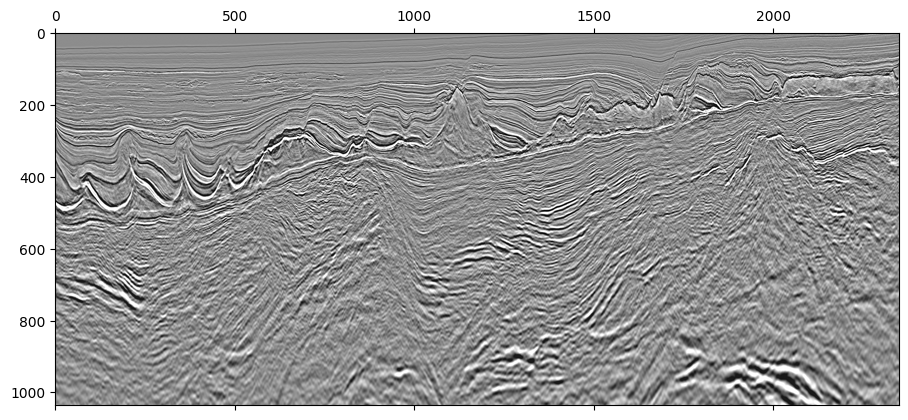

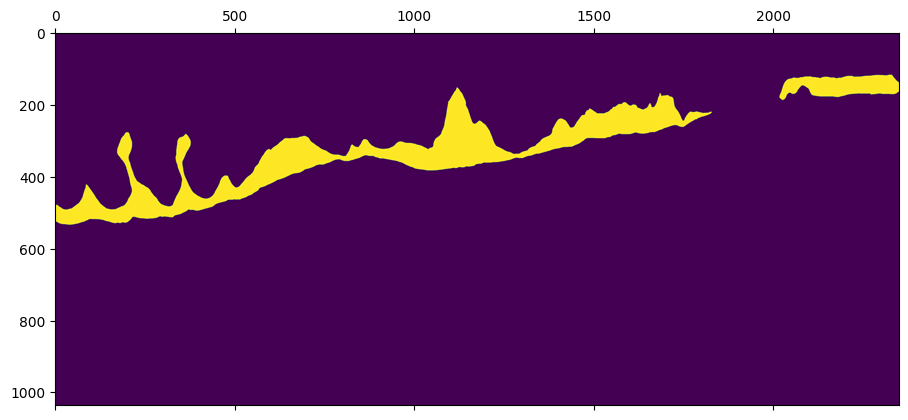

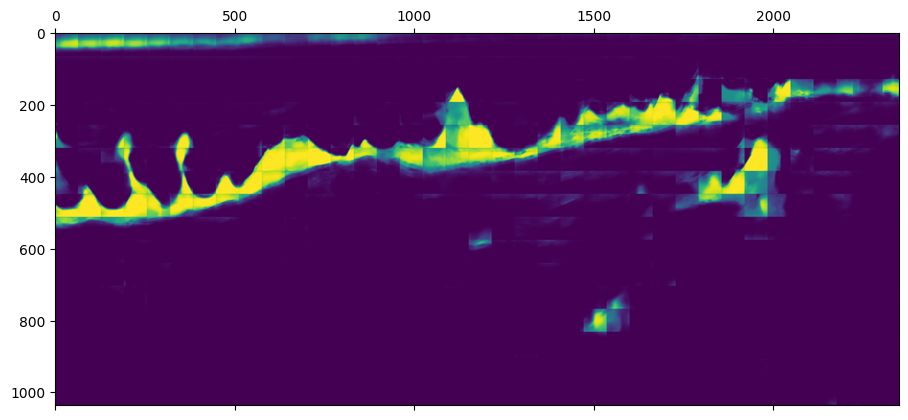

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# ---------------- TILING FUNCTION WITH OVERLAP ----------------
def tile(data, wsize, dt, dx):
    t_max, x_max, _ = data.shape
    patches = []
    positions = []

    for t in range(0, t_max - wsize + 1, dt):
        for x in range(0, x_max - wsize + 1, dx):
            patch = data[t:t + wsize, x:x + wsize, 0]
            patches.append(patch)
            positions.append((t, x))

    # Handle right and bottom edges
    if t_max % dt != 0:
        for x in range(0, x_max - wsize + 1, dx):
            patches.append(data[t_max - wsize:t_max, x:x + wsize, 0])
            positions.append((t_max - wsize, x))

    if x_max % dx != 0:
        for t in range(0, t_max - wsize + 1, dt):
            patches.append(data[t:t + wsize, x_max - wsize:x_max, 0])
            positions.append((t, x_max - wsize))

    # Bottom-right corner
    if t_max % dt != 0 and x_max % dx != 0:
        patches.append(data[t_max - wsize:t_max, x_max - wsize:x_max, 0])
        positions.append((t_max - wsize, x_max - wsize))

    # Stack patches and add channel dimension
    data_patch = np.stack(patches)[..., np.newaxis]
    return data_patch, positions

# ---------------- MERGING FUNCTION ----------------
def merge(data_patches, positions, t_max, x_max, wsize):
    output = np.zeros((t_max, x_max, 1))
    count = np.zeros((t_max, x_max, 1))

    for idx, (t, x) in enumerate(positions):
        output[t:t + wsize, x:x + wsize, 0] += data_patches[idx, :, :, 0]
        count[t:t + wsize, x:x + wsize, 0] += 1

    count[count == 0] = 1  # Prevent divide-by-zero
    return output / count

# ---------------- PARAMETERS ----------------
patch_size = 128            # Patch size for model
overlap = patch_size // 2   # 50% overlap
dt = patch_size - overlap
dx = patch_size - overlap
t_max, x_max, _ = data.shape

# ---------------- PROCESSING ----------------
# 1. Tile the full seismic section
data_tiles, tile_positions = tile(data, patch_size, dt, dx)

# 2. Predict on tiles in batches
result_tiles = model.predict(data_tiles, batch_size=32, verbose=1)

# 3. Merge the predictions back into the full image
result = merge(result_tiles, tile_positions, t_max, x_max, patch_size)

# ---------------- VISUALIZATION ----------------
plt.matshow(data[:, :, 0], cmap='gray', interpolation='spline16')
plt.matshow(mask, interpolation='spline16')
plt.matshow(result[:, :, 0], interpolation='spline16')
plt.show()


Awesome! The model did a pretty good job on the training data (left side of the image), but on yet unseen data (right side of the image), it struggles a bit. In the next tutorial ([tutorial-3](https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-3/tutorial_3.ipynb)), you will learn how to fix this
